## 1 导入数据

In [1]:
import numpy as np
import pandas as pd
import os

path = 'data/'

# 读取商铺流水数据
loss_data_final = pd.read_csv(os.path.join(path, 'loss_transaction/table_lend_transaction_final.txt'), sep = ',')
print(loss_data_final)
loss_data = loss_data_final.copy()

# 读取历史还款数据
history_loan_data = pd.read_csv(os.path.join(path, 'history_loan/table_datamining_history_loan.txt'), sep = ',')
print('\n history_loan_data  \n')
print(history_loan_data)
print('\n')

# 读取商铺数据
merchant_data = pd.read_csv(os.path.join(path, 'merchant/table_datamining_merchant.txt'), sep = ',')
print('\n merchant_data  \n')
print(merchant_data)
print('\n')

# 读取贷款数据
loan_data_train = pd.read_csv(os.path.join(path, 'loan/table_loan_train.txt'), sep = ',')
print('\n loan_data_train  \n')
print(loan_data_train)
print('\n')

loan_data_test = pd.read_csv(os.path.join(path, 'loan/table_loan_test.txt'), sep = ',')
#print(loan_data_test)


                        id  type  status         store_id      merchant_id  \
0        t7895258646038403    30    2001  292289830769797  516101438346939   
1        t7895258646051854    30    2000  753408387511040  965952426216589   
2        t7895258646061341    30    2000  487886544602057  865666381695711   
3        t7895258646069041    30    2000  184152043581967  628144392905567   
4        t7895258646082247    30    2000  648228836923143   35792493305336   
...                    ...   ...     ...              ...              ...   
3590054  t7895258064078196    30    2001  789908637764433  174796936272853   
3590055  t7895258064078399    30    2000  745577543103205  978316913256025   
3590056  t7895258064090212    30    2000  681061753579100  536592880791599   
3590057  t7895258064122128    30    2000  299422691655945  188638695193641   
3590058  t7895258064128306    30    2000   73605323921266   58429978598916   

         pay_way  sub_pay_way paid_amount          ctime  bankc

## 2 数据预处理

### 2.1 商铺流水数据

In [2]:
# 将流水数据与训练集merge，方便后续操作
loss_data_final = loan_data_train.merge(loss_data_final, on='merchant_id', how='left')
print(loss_data_final.info())

loss_data_final.to_csv("loss_data_final.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676836 entries, 0 to 2676835
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   apply_id               int64  
 1   merchant_id            int64  
 2   apply_date             object 
 3   lend_amount            float64
 4   lend_period            int64  
 5   is_30days_overdue      int64  
 6   id                     object 
 7   type                   float64
 8   status                 float64
 9   store_id               float64
 10  pay_way                float64
 11  sub_pay_way            float64
 12  paid_amount            object 
 13  ctime                  float64
 14  bankcard_credit        float64
 15  bankcard_debit         float64
 16  wallet_weixin          float64
 17  wallet_alipay          float64
 18  wallet_alipay_finance  float64
 19  alipay_huabei          float64
 20  alipay_point           float64
 21  pt                     float64
dtypes: float64(15), in

In [3]:
loss_data_final['apply_date'] = pd.to_datetime(loss_data_final['apply_date'])
loss_data_final['pt'] = pd.to_datetime(loss_data_final['pt'], format='%Y%m%d')
loss_data_final['bankcard_credit'] = pd.to_numeric(loss_data_final['bankcard_credit'])
loss_data_final['bankcard_debit'] = pd.to_numeric(loss_data_final['bankcard_debit'])
loss_data_final['wallet_weixin'] = pd.to_numeric(loss_data_final['wallet_weixin'])
loss_data_final['wallet_alipay'] = pd.to_numeric(loss_data_final['wallet_alipay'])
loss_data_final['wallet_alipay_finance'] = pd.to_numeric(loss_data_final['wallet_alipay_finance'])
loss_data_final['alipay_huabei'] = pd.to_numeric(loss_data_final['alipay_huabei'])
loss_data_final['alipay_point'] = pd.to_numeric(loss_data_final['alipay_point'])

In [4]:
# 删除已取消的交易（loss_data_final['type']值为10的行）
loss_data_final = loss_data_final[loss_data_final['type'] != 10]
print("删除已取消的交易后，流水数据的数据量为", loss_data_final.shape[0])

# 删除无意义的交易（即'paid_amount'为'\N'且bankcard_credit、bankcard_debit、wallet_weixin、wallet_alipay、wallet_alipay_finance、alipay_huabei、alipay_point的值均为0的列）
loss_data_final['paid_amount'] = loss_data_final['paid_amount'].replace(r'\N', np.nan) # 将‘\N’替换为空值
loss_data_final['paid_amount'] = pd.to_numeric(loss_data_final['paid_amount'])# 将['paid_amount']列转换为数字类型，方便求均值
meaningless_transactions = loss_data_final[(loss_data_final['paid_amount'].isnull()) & 
                                           (loss_data_final['bankcard_credit'] == 0) &
                                           (loss_data_final['bankcard_debit'] == 0) &
                                           (loss_data_final['wallet_weixin'] == 0) &
                                           (loss_data_final['wallet_alipay'] == 0) &
                                           (loss_data_final['wallet_alipay_finance'] == 0) &
                                           (loss_data_final['alipay_huabei'] == 0) &
                                           (loss_data_final['alipay_point'] == 0)] # 创建条件索引，找出'paid_amount'为NaN且其他支付方式均为0的行
loss_data_final.drop(meaningless_transactions.index, inplace=True)
print("删除无意义的交易后，流水数据的数据量为：", loss_data_final.shape[0])

# 对于['paid_amount']列，使用该商铺该日收入均值替代值为‘\N’的列
store_income_per_day = loss_data_final.groupby(['store_id'])['paid_amount'].mean() # 使用该商铺的日收入均值替代空值
print(store_income_per_day)
store_income_per_day = store_income_per_day.astype('O')
loss_data_final['paid_amount'].fillna(loss_data_final.apply(lambda row: store_income_per_day.get((row['store_id'])), axis=1), inplace=True)

#loss_data_final['paid_amount'] = loss_data_final['paid_amount'].fillna(store_income_per_day)
print("替换后，流水数据为：", loss_data_final)

删除已取消的交易后，流水数据的数据量为 2675692
删除无意义的交易后，流水数据的数据量为： 2556734
store_id
6.504803e+10     12515.696809
4.086940e+11     29974.285714
1.260179e+12      3604.256345
3.339298e+12      2168.592593
3.698826e+12     34832.755780
                    ...      
9.943079e+14      2445.627072
9.953695e+14    200918.625000
9.965617e+14      4703.714286
9.966627e+14     10638.759036
9.986614e+14      3219.462705
Name: paid_amount, Length: 1242, dtype: float64


/var/folders/l8/wygybflx5kv0zwk02x748tn80000gn/T/ipykernel_37529/1025909531.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loss_data_final['paid_amount'].fillna(loss_data_final.apply(lambda row: store_income_per_day.get((row['store_id'])), axis=1), inplace=True)


替换后，流水数据为：          apply_id      merchant_id apply_date  lend_amount  lend_period  \
0        53143959  408215340609460 2018-06-11      50000.0           12   
1        53143959  408215340609460 2018-06-11      50000.0           12   
2        53143959  408215340609460 2018-06-11      50000.0           12   
3        53143959  408215340609460 2018-06-11      50000.0           12   
4        53143959  408215340609460 2018-06-11      50000.0           12   
...           ...              ...        ...          ...          ...   
2676831  51179154  577445869192447 2018-05-23      12000.0            4   
2676832  51179154  577445869192447 2018-05-23      12000.0            4   
2676833  51179154  577445869192447 2018-05-23      12000.0            4   
2676834  51179154  577445869192447 2018-05-23      12000.0            4   
2676835  51179154  577445869192447 2018-05-23      12000.0            4   

         is_30days_overdue                 id  type  status      store_id  \
0          

In [5]:
loss_data_final['paid_amount'] = loss_data_final['paid_amount'] / 100
loss_data_final['bankcard_credit'] = loss_data_final['bankcard_credit'] / 100
loss_data_final['bankcard_debit'] = loss_data_final['bankcard_debit'] / 100
loss_data_final['wallet_weixin'] = loss_data_final['wallet_weixin'] / 100
loss_data_final['wallet_alipay'] = loss_data_final['wallet_alipay'] /100
loss_data_final['wallet_alipay_finance'] = loss_data_final['wallet_alipay_finance'] / 100
loss_data_final['alipay_huabei'] = loss_data_final['alipay_huabei'] / 100
loss_data_final['alipay_point'] = loss_data_final['alipay_point'] / 100
print(loss_data_final)

         apply_id      merchant_id apply_date  lend_amount  lend_period  \
0        53143959  408215340609460 2018-06-11      50000.0           12   
1        53143959  408215340609460 2018-06-11      50000.0           12   
2        53143959  408215340609460 2018-06-11      50000.0           12   
3        53143959  408215340609460 2018-06-11      50000.0           12   
4        53143959  408215340609460 2018-06-11      50000.0           12   
...           ...              ...        ...          ...          ...   
2676831  51179154  577445869192447 2018-05-23      12000.0            4   
2676832  51179154  577445869192447 2018-05-23      12000.0            4   
2676833  51179154  577445869192447 2018-05-23      12000.0            4   
2676834  51179154  577445869192447 2018-05-23      12000.0            4   
2676835  51179154  577445869192447 2018-05-23      12000.0            4   

         is_30days_overdue                 id  type  status      store_id  \
0                     

In [6]:
# 将在apply_date之前30天的流水数据视为有效数据，删除其他数据
loss_data_final = loss_data_final[(loss_data_final['apply_date'] - loss_data_final['pt']).dt.days.le(30)]
print(loss_data_final)

         apply_id      merchant_id apply_date  lend_amount  lend_period  \
100      53143959  408215340609460 2018-06-11      50000.0           12   
101      53143959  408215340609460 2018-06-11      50000.0           12   
102      53143959  408215340609460 2018-06-11      50000.0           12   
103      53143959  408215340609460 2018-06-11      50000.0           12   
104      53143959  408215340609460 2018-06-11      50000.0           12   
...           ...              ...        ...          ...          ...   
2676825  51179154  577445869192447 2018-05-23      12000.0            4   
2676828  51179154  577445869192447 2018-05-23      12000.0            4   
2676832  51179154  577445869192447 2018-05-23      12000.0            4   
2676833  51179154  577445869192447 2018-05-23      12000.0            4   
2676834  51179154  577445869192447 2018-05-23      12000.0            4   

         is_30days_overdue                 id  type  status      store_id  \
100                   

### 2.2 历史贷款数据

In [7]:
history_loan_data['lend_amount'] = pd.to_numeric(history_loan_data['lend_amount'])
print(history_loan_data)

     apply_id      merchant_id           apply_date  lend_amount  lend_period  \
0     9664605   41973696425690  2017-03-08 00:00:00      20000.0            6   
1    20869326  175783930702994  2017-07-16 00:00:00      15000.0            4   
2    12498066  175783930702994  2017-04-18 00:00:00      15000.0           12   
3    17493251  175783930702994  2017-06-10 00:00:00      20000.0            3   
4    15656214  175783930702994  2017-05-28 00:00:00       5000.0            1   
..        ...              ...                  ...          ...          ...   
348  20548822  671059822241463  2017-07-12 00:00:00      17000.0           12   
349  20940049  915025426447525  2017-07-17 00:00:00       8000.0            6   
350  32746831  966171201249254  2017-11-29 00:00:00       8000.0            3   
351  23923765  966171201249254  2017-08-22 00:00:00       8000.0            3   
352  21495358  497377049261045  2017-07-24 00:00:00      12000.0            6   

    notional_settle_date   

## 3 数据特征提取

### 3.1 商铺流水数据

#### 3.1.1 商户平均每日消费者支付金额、平均每日红包使用金额

In [8]:
# 商户申请前30天平均每单消费者支付金额
merchant_income_per_order = loss_data_final.groupby(['merchant_id', 'apply_date'])['paid_amount'].mean().reset_index(name='merchant_income_per_order')
print(merchant_income_per_order)

#merchant_income_per_order.to_csv('merchant_income_per_order.csv')

# 商户申请前30天平均每日红包使用金额
loss_data_final['red_envelope'] = loss_data_final['paid_amount'] - loss_data_final[['bankcard_credit', 
                                                                                    'bankcard_debit', 
                                                                                    'wallet_weixin', 
                                                                                    'wallet_alipay', 
                                                                                    'wallet_alipay_finance', 
                                                                                    'alipay_huabei', 
                                                                                    'alipay_point']].sum(axis=1)

merchant_red_envelope = loss_data_final.groupby(
    ['merchant_id', 'apply_date', loss_data_final['pt'].dt.date])['red_envelope'].sum()
merchant_red_envelope_per_day = merchant_red_envelope.groupby(
    ['merchant_id', 'apply_date']).mean().reset_index(name='red_envelope_per_day')
print(merchant_red_envelope_per_day)

          merchant_id apply_date  merchant_income_per_order
0        762310083866 2018-05-02                 136.105679
1       1676030187902 2018-06-09                   7.225627
2       1782234936129 2018-06-04                  17.885975
3       3033389109799 2018-05-07                   6.725548
4       3366806736059 2018-06-15                 100.000000
...               ...        ...                        ...
1101  994645764571114 2018-06-06                  24.005611
1102  994652092978753 2018-05-01                  59.360708
1103  994854574471832 2018-06-03                  21.757767
1104  996811711585523 2018-06-01                 237.048298
1105  997572759685728 2018-05-06                1451.335333

[1106 rows x 3 columns]
          merchant_id apply_date  red_envelope_per_day
0        762310083866 2018-05-02              6.915200
1       1676030187902 2018-06-09              0.648649
2       1782234936129 2018-06-04              0.547619
3       3033389109799 2018-05-07   

#### 3.1.2 商户储蓄卡、微信余额、支付宝余额、支付宝余额宝的平均每日消费者支付金额，商户信用卡、花呗、集分宝的平均每日消费者支付金额

In [9]:
# 商户储蓄卡(D)、微信余额(W)、支付宝余额(A)、支付宝余额宝(AF)的平均每日消费者支付金额（申请前30天）
loss_data_final['D_W_A_AF'] = loss_data_final[['bankcard_debit', 'wallet_weixin', 'wallet_alipay', 'wallet_alipay_finance']].sum(axis=1)
merchant_mean_daily_payment = loss_data_final.groupby(['merchant_id', 'apply_date'])['D_W_A_AF'].mean()

# 商户信用卡(C)、花呗(H)、集分宝(P)的平均每日消费者支付金额（申请前30天）
loss_data_final['C_H_P'] = loss_data_final[['bankcard_credit', 'alipay_huabei', 'alipay_point']].sum(axis=1)
merchant_mean_daily_payment_credit_huabei_point = loss_data_final.groupby(['merchant_id', 'apply_date'])['C_H_P'].mean()

print("商户储蓄卡、微信余额、支付宝余额、支付宝余额宝的平均每日消费者支付金额：")
print(merchant_mean_daily_payment)

print("\n商户信用卡、花呗、集分宝的平均每日消费者支付金额：")
print(merchant_mean_daily_payment_credit_huabei_point)

商户储蓄卡、微信余额、支付宝余额、支付宝余额宝的平均每日消费者支付金额：
merchant_id      apply_date
762310083866     2018-05-02    106.822362
1676030187902    2018-06-09      6.095030
1782234936129    2018-06-04     12.877924
3033389109799    2018-05-07      6.580649
3366806736059    2018-06-15      0.000000
                                  ...    
994645764571114  2018-06-06     20.127143
994652092978753  2018-05-01     10.578678
994854574471832  2018-06-03     11.185767
996811711585523  2018-06-01    194.953723
997572759685728  2018-05-06    397.224000
Name: D_W_A_AF, Length: 1106, dtype: float64

商户信用卡、花呗、集分宝的平均每日消费者支付金额：
merchant_id      apply_date
762310083866     2018-05-02      28.648507
1676030187902    2018-06-09       1.118561
1782234936129    2018-06-04       4.971601
3033389109799    2018-05-07       0.092919
3366806736059    2018-06-15     100.000000
                                  ...     
994645764571114  2018-06-06       3.847412
994652092978753  2018-05-01      48.770294
994854574471832  2018-06-03  

#### 3.1.3 商户交易活动度（交易次数、交易总金额、交易金额的标准差）

In [10]:
# 根据商户分组并计算交易总金额和交易金额的标准差（申请前30天）
merchant_activity = loss_data_final.groupby(
    ['merchant_id', 'apply_date', loss_data_final['pt'].dt.date])['paid_amount'].sum()
merchant_activity_per_day = merchant_activity.groupby(['merchant_id', 'apply_date']).std()

# 重命名列名
merchant_activity_per_day.columns = ['transaction_amount_std']
merchant_activity_per_day = merchant_activity_per_day.reset_index(name='transaction_amount_per_day_std')

# 显示结果
print(merchant_activity_per_day)
print(merchant_activity_per_day.info())

          merchant_id apply_date  transaction_amount_per_day_std
0        762310083866 2018-05-02                     1617.707225
1       1676030187902 2018-06-09                      327.394540
2       1782234936129 2018-06-04                      423.737259
3       3033389109799 2018-05-07                      132.878874
4       3366806736059 2018-06-15                             NaN
...               ...        ...                             ...
1101  994645764571114 2018-06-06                      298.455365
1102  994652092978753 2018-05-01                     3057.907385
1103  994854574471832 2018-06-03                      313.775503
1104  996811711585523 2018-06-01                      670.389710
1105  997572759685728 2018-05-06                     6076.156425

[1106 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------          

In [11]:
print(loss_data_final['apply_id'].unique().shape[0])


1106


#### 3.1.4 商户信用卡支付金额与总支付金额的比例、花呗支付金额与总支付金额的比例

In [12]:
# 计算每个商户的总支付金额（申请前30天）
total_payment_per_merchant = loss_data_final.groupby(['merchant_id', 'apply_date'])[['bankcard_debit', 'wallet_weixin', 'wallet_alipay', 'wallet_alipay_finance', 'bankcard_credit', 'alipay_huabei', 'alipay_point']].sum()
total_payment_per_merchant['total_payment'] = total_payment_per_merchant.sum(axis=1)

# 计算信用卡支付金额与总支付金额的比例（申请前30天）
credit_card_payment_ratio_per_merchant = total_payment_per_merchant['bankcard_credit'] / total_payment_per_merchant['total_payment']
credit_card_payment_ratio_per_merchant = credit_card_payment_ratio_per_merchant.reset_index(name='credit_card_ratio')
# 计算花呗支付金额与总支付金额的比例（申请前30天）
huabei_payment_ratio_per_merchant = total_payment_per_merchant['alipay_huabei'] / total_payment_per_merchant['total_payment']
huabei_payment_ratio_per_merchant = huabei_payment_ratio_per_merchant.reset_index(name='huabei_ratio')

# 显示结果
print("信用卡支付金额与总支付金额的比例（按商户）：")
print(credit_card_payment_ratio_per_merchant)

print("\n花呗支付金额与总支付金额的比例（按商户）：")
print(huabei_payment_ratio_per_merchant)

信用卡支付金额与总支付金额的比例（按商户）：
          merchant_id apply_date  credit_card_ratio
0        762310083866 2018-05-02           0.149929
1       1676030187902 2018-06-09           0.048886
2       1782234936129 2018-06-04           0.068637
3       3033389109799 2018-05-07           0.013923
4       3366806736059 2018-06-15           0.000000
...               ...        ...                ...
1101  994645764571114 2018-06-06           0.032918
1102  994652092978753 2018-05-01           0.654964
1103  994854574471832 2018-06-03           0.447605
1104  996811711585523 2018-06-01           0.138220
1105  997572759685728 2018-05-06           0.726304

[1106 rows x 3 columns]

花呗支付金额与总支付金额的比例（按商户）：
          merchant_id apply_date  huabei_ratio
0        762310083866 2018-05-02      0.061544
1       1676030187902 2018-06-09      0.106177
2       1782234936129 2018-06-04      0.209892
3       3033389109799 2018-05-07      0.000000
4       3366806736059 2018-06-15      1.000000
...               ...  

#### 3.1.5 交易频率、交易金额统计特征（平均值、总额、最大值、最小值）

In [13]:
# 计算每个商户的交易次数（申请前30天）
transaction_count_per_merchant = loss_data_final.groupby(['merchant_id', 'apply_date']).size().reset_index(name='transaction_total_count')

# 计算每个商户每日平均交易次数（申请前30天）
transaction_count_per_day = loss_data_final.groupby(
    ['merchant_id', 'apply_date', loss_data_final['pt'].dt.date]).size()
transaction_count_per_day_per_merchant = transaction_count_per_day.groupby(
    ['merchant_id', 'apply_date']).mean().reset_index(name='transaction_count_per_day')

# 计算每个商户的交易金额统计特征（申请前30天）
transaction_amount_statistics_per_merchant = loss_data_final.groupby(['merchant_id', 'apply_date', loss_data_final['pt'].dt.date])['paid_amount'].sum()
transaction_amount_statistics_per_merchant_per_day = transaction_amount_statistics_per_merchant.groupby(['merchant_id', 'apply_date']).agg(['mean', 'sum', 'max', 'min']).reset_index()

# 打印结果
print("每个商户的交易总数：")
print(transaction_count_per_merchant)

print("每个商户平均每日交易数量：")
print(transaction_count_per_day_per_merchant)

print("\n每个商户的交易金额统计特征：")
print(transaction_amount_statistics_per_merchant_per_day)

每个商户的交易总数：
          merchant_id apply_date  transaction_total_count
0        762310083866 2018-05-02                      817
1       1676030187902 2018-06-09                     1994
2       1782234936129 2018-06-04                      631
3       3033389109799 2018-05-07                     3515
4       3366806736059 2018-06-15                        1
...               ...        ...                      ...
1101  994645764571114 2018-06-06                      483
1102  994652092978753 2018-05-01                     2246
1103  994854574471832 2018-06-03                      215
1104  996811711585523 2018-06-01                       94
1105  997572759685728 2018-05-06                       45

[1106 rows x 3 columns]
每个商户平均每日交易数量：
          merchant_id apply_date  transaction_count_per_day
0        762310083866 2018-05-02                  10.893333
1       1676030187902 2018-06-09                  53.891892
2       1782234936129 2018-06-04                  15.023810
3       303338

### 3.2 历史贷款申请数据

#### 3.2.1 同一贷款人 id 贷款次数、逾期 30 天还款现象的贷款交易数、未逾期还贷频率、逾期率（逾期的次数与总贷款次数的比值）、是否出现最后还款期限内未还完的情况（通过理论结清日和实际结清日判断

In [14]:
history_loan_data["notional_settle_date"] = pd.to_datetime(history_loan_data["notional_settle_date"])
history_loan_data["real_settle_date"] = pd.to_datetime(history_loan_data["real_settle_date"])

In [15]:
# 创建包含所有 merchant_id 的 DataFrame
all_merchant_ids = history_loan_data['merchant_id'].unique()
all_merchants = pd.DataFrame({'merchant_id': all_merchant_ids})

# 计算同一贷款人的贷款次数
loan_count_per_borrower = history_loan_data.groupby('merchant_id').size().reset_index(name='loan_count')

# 计算逾期 30 天还款现象的贷款交易数（添加默认值为0，避免计算逾期率和未逾期率时出现NAN的情况）
overdue_30_days_count = history_loan_data[history_loan_data['is_30days_overdue'] == 1].groupby('merchant_id').size().reset_index(name='overdue_count')
overdue_30_days_count = all_merchants.merge(overdue_30_days_count, how='left', left_on='merchant_id', right_on='merchant_id') # 将计算得到的逾期交易数与所有贷款人合并，并使用默认值 0 填充缺失值
overdue_30_days_count['overdue_count'] = overdue_30_days_count['overdue_count'].fillna(0) # 为了防止后续计算逾期率和未逾期率时无法找到逾期30天的次数为0的商户而导致出现NAN的情况

# 计算逾期还贷频率
history_merged_data = loan_count_per_borrower.merge(overdue_30_days_count, on='merchant_id', how='left')
history_merged_data['overdue_rate'] = history_merged_data['overdue_count'] / history_merged_data['loan_count']

# 计算未逾期还款率
history_merged_data['non_overdue_count'] = history_merged_data['loan_count'] - history_merged_data['overdue_count']
history_merged_data['non_overdue_rate'] = history_merged_data['non_overdue_count'] / history_merged_data['loan_count']

# 判断是否出现最后还款期限内未还完的情况
history_loan_data['is_not_fully_repaid'] = (history_loan_data['notional_settle_date'] < history_loan_data['real_settle_date'])

# 按贷款人ID计算是否出现最后还款期限内未还完的情况
not_fully_repaid_per_borrower = history_loan_data.groupby('merchant_id')['is_not_fully_repaid'].any()

# 打印结果
print("同一贷款人的贷款次数：")
print(loan_count_per_borrower)

print("\n逾期 30 天还款现象的贷款交易数：")
print(overdue_30_days_count)

print("\n未逾期还贷频率：")
print(history_merged_data[['merchant_id', 'non_overdue_rate']])

print("\n逾期率：")
print(history_merged_data[['merchant_id', 'overdue_rate']])

print("\n是否出现最后还款期限内未还完的情况：")
print(not_fully_repaid_per_borrower)
print("\n出现最后还款期限内未还完的情况的数量：", (history_loan_data['is_not_fully_repaid'] == True).sum())

同一贷款人的贷款次数：
         merchant_id  loan_count
0       751583638317           1
1      1782234936129           1
2     17057045800892           1
3     20432892828619           2
4     23977383928717           1
..               ...         ...
264  977922938114444           1
265  988580183586241           1
266  989840099406088           1
267  990771863905824           2
268  997267937584480           1

[269 rows x 2 columns]

逾期 30 天还款现象的贷款交易数：
         merchant_id  overdue_count
0     41973696425690            0.0
1    175783930702994            0.0
2     37740656205727            1.0
3    569468845853568            0.0
4    473359066685652            1.0
..               ...            ...
264  339900431712051            1.0
265  671059822241463            0.0
266  915025426447525            1.0
267  966171201249254            2.0
268  497377049261045            1.0

[269 rows x 2 columns]

未逾期还贷频率：
         merchant_id  non_overdue_rate
0       751583638317               0.0
1   

#### 3.2.2 实际还款和理论还款之间的天数差异

In [16]:
# 计算实际还款和理论还款之间的天数差异
history_loan_data['repayment_delay_days'] = (history_loan_data['real_settle_date'] - history_loan_data['notional_settle_date']).dt.days
# 商户平均每笔贷款实际还款和理论还款之间的天数差异
mean_delay_days_per_merchant = history_loan_data.groupby('merchant_id')['repayment_delay_days'].mean().reset_index()

print(history_loan_data['repayment_delay_days'])
print(mean_delay_days_per_merchant)

0     -121
1      -20
2     -351
3      -84
4      -21
      ... 
348   -161
349    -31
350      0
351     -1
352      0
Name: repayment_delay_days, Length: 353, dtype: int64
         merchant_id  repayment_delay_days
0       751583638317                   0.0
1      1782234936129                  -1.0
2     17057045800892                   0.0
3     20432892828619                  -0.5
4     23977383928717                 -54.0
..               ...                   ...
264  977922938114444                   0.0
265  988580183586241                   0.0
266  989840099406088                -162.0
267  990771863905824                -155.5
268  997267937584480                 -88.0

[269 rows x 2 columns]


#### 3.2.3 商户对应的有逾期 30 天还款现象的次数（要通过计算理论结清日与实际结清日进行重新计算）、商户对应的没有出现逾期 30 天还款现象的次数（要通过计算理论结清日与实际结清日进行重新计算）

In [17]:
# 计算历史有逾期30天还款现象的次数
history_overdue_counts = (history_loan_data['real_settle_date'] - history_loan_data['notional_settle_date']).dt.days.ge(30).groupby(history_loan_data['merchant_id']).sum().reset_index(name='history_30_overdue_counts')
# 计算历史没有出现逾期30天还款现象的次数
history_no_overdue_counts = (history_loan_data['real_settle_date'] - history_loan_data['notional_settle_date']).dt.days.lt(30).groupby(history_loan_data['merchant_id']).sum()

# 打印结果
print("历史有逾期 30 天还款现象的次数：\n", history_overdue_counts)
print("\n历史没有出现逾期 30 天还款现象的次数：\n", history_no_overdue_counts)

历史有逾期 30 天还款现象的次数：
          merchant_id  history_30_overdue_counts
0       751583638317                          0
1      1782234936129                          0
2     17057045800892                          0
3     20432892828619                          0
4     23977383928717                          0
..               ...                        ...
264  977922938114444                          0
265  988580183586241                          0
266  989840099406088                          0
267  990771863905824                          0
268  997267937584480                          0

[269 rows x 2 columns]

历史没有出现逾期 30 天还款现象的次数：
 merchant_id
751583638317       1
1782234936129      1
17057045800892     1
20432892828619     2
23977383928717     1
                  ..
977922938114444    1
988580183586241    1
989840099406088    1
990771863905824    2
997267937584480    1
Length: 269, dtype: int64


#### 3.2.5 商户逾期率与平均贷款期数的比值

In [18]:
# 计算商户平均贷款期数
mean_loan_period = history_loan_data.groupby('merchant_id')['lend_period'].mean().reset_index(name='mean_loan_period')
history_merged_data = history_merged_data.merge(mean_loan_period, on='merchant_id', how='left')

history_merged_data['overdue_rate/mean_loan_period'] = history_merged_data['overdue_rate'] / history_merged_data['mean_loan_period']
print(history_merged_data)

         merchant_id  loan_count  overdue_count  overdue_rate  \
0       751583638317           1            1.0           1.0   
1      1782234936129           1            0.0           0.0   
2     17057045800892           1            1.0           1.0   
3     20432892828619           2            1.0           0.5   
4     23977383928717           1            0.0           0.0   
..               ...         ...            ...           ...   
264  977922938114444           1            0.0           0.0   
265  988580183586241           1            1.0           1.0   
266  989840099406088           1            0.0           0.0   
267  990771863905824           2            0.0           0.0   
268  997267937584480           1            0.0           0.0   

     non_overdue_count  non_overdue_rate  mean_loan_period  \
0                  0.0               0.0               6.0   
1                  1.0               1.0               2.0   
2                  0.0           

#### 3.2.6 商户历史贷款总金额、历史平均贷款期数

In [19]:
# 计算商户历史贷款总金额
history_total_loan_amount = history_loan_data.groupby('merchant_id')['lend_amount'].sum().reset_index(name='history_total_loan_amount')

# 计算商户历史平均贷款期数
history_mean_loan_period = history_loan_data.groupby('merchant_id')['lend_period'].mean()

# 打印结果
print("商户历史贷款总金额：\n", history_total_loan_amount)
print("\n商户历史平均贷款期数：\n", history_mean_loan_period)

商户历史贷款总金额：
          merchant_id  history_total_loan_amount
0       751583638317                     8000.0
1      1782234936129                    20000.0
2     17057045800892                     3000.0
3     20432892828619                    53000.0
4     23977383928717                     5000.0
..               ...                        ...
264  977922938114444                   100000.0
265  988580183586241                    10000.0
266  989840099406088                    19000.0
267  990771863905824                     8000.0
268  997267937584480                    16000.0

[269 rows x 2 columns]

商户历史平均贷款期数：
 merchant_id
751583638317        6.0
1782234936129       2.0
17057045800892      6.0
20432892828619      3.5
23977383928717      6.0
                   ... 
977922938114444     3.0
988580183586241     6.0
989840099406088    12.0
990771863905824     6.0
997267937584480     3.0
Name: lend_period, Length: 269, dtype: float64


#### 3.2.7 还款金额统计特征：平均值、总额、最大值、最小值等

In [20]:
# 计算还款金额和历史还款金额的统计特征
history_repayment_stats = history_loan_data['lend_amount'].describe()

# 打印结果
print("历史还款金额统计特征\n:",history_repayment_stats)

历史还款金额统计特征
: count       353.000000
mean      17371.104816
std       22160.467544
min        1000.000000
25%        5000.000000
50%       10000.000000
75%       20000.000000
max      200000.000000
Name: lend_amount, dtype: float64


## 4 数据整合 

In [21]:
# 流水数据
loan_data_train['apply_date'] = pd.to_datetime(loan_data_train['apply_date'])
# 商户金额均值（每日
df_train = loan_data_train.merge(transaction_amount_statistics_per_merchant_per_day[['merchant_id', 'apply_date', 'mean']], on=['merchant_id', 'apply_date'], how='left')
# 商户金额标准差（每日
df_train = df_train.merge(merchant_activity_per_day, on=['merchant_id', 'apply_date'], how='left')
# 商户平均每日交易数
df_train = df_train.merge(transaction_count_per_day_per_merchant, on=['merchant_id', 'apply_date'], how='left')
# 平均每日红包使用金额
df_train = df_train.merge(merchant_red_envelope_per_day, on=['merchant_id', 'apply_date'], how='left')
# 花呗/信用卡支付占该商铺总支付金额的占比
df_train = df_train.merge(huabei_payment_ratio_per_merchant, on=['merchant_id', 'apply_date'], how='left')
df_train = df_train.merge(credit_card_payment_ratio_per_merchant, on=['merchant_id', 'apply_date'], how='left')
df_train = df_train.select_dtypes(include=['float64', 'int64'])
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   apply_id                        1200 non-null   int64  
 1   merchant_id                     1200 non-null   int64  
 2   lend_amount                     1200 non-null   float64
 3   lend_period                     1200 non-null   int64  
 4   is_30days_overdue               1200 non-null   int64  
 5   mean                            1106 non-null   float64
 6   transaction_amount_per_day_std  1076 non-null   float64
 7   transaction_count_per_day       1106 non-null   float64
 8   red_envelope_per_day            1106 non-null   float64
 9   huabei_ratio                    1106 non-null   float64
 10  credit_card_ratio               1106 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 103.3 KB
None


### 4.1 对于商铺流水数据，使用knn插补法对空缺值进行补全

In [22]:
#使用KNN插补对空缺值进行填补
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df = df_train.copy()
df = df.drop(columns=['apply_id', 'merchant_id'])

def optimize_k(data, target):
    errors = []
    for k in range(1, 12, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(df)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = mean_squared_error(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

k_errors = optimize_k(data=df, target=['mean', 'transaction_amount_per_day_std', 
                                       'transaction_count_per_day', 'red_envelope_per_day', 'huabei_ratio', 'credit_card_ratio'])
print(k_errors)

[{'K': 1, 'RMSE': 3570198.0909116273}, {'K': 3, 'RMSE': 3531856.7963006985}, {'K': 5, 'RMSE': 3516003.165635926}, {'K': 7, 'RMSE': 3421932.8791541606}, {'K': 9, 'RMSE': 3470486.1463334374}, {'K': 11, 'RMSE': 3395717.2506384137}]


In [23]:
#使用KNN插补对空缺值进行填补
imputer = KNNImputer(n_neighbors=11)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)

print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lend_amount                     1200 non-null   float64
 1   lend_period                     1200 non-null   float64
 2   is_30days_overdue               1200 non-null   float64
 3   mean                            1200 non-null   float64
 4   transaction_amount_per_day_std  1200 non-null   float64
 5   transaction_count_per_day       1200 non-null   float64
 6   red_envelope_per_day            1200 non-null   float64
 7   huabei_ratio                    1200 non-null   float64
 8   credit_card_ratio               1200 non-null   float64
dtypes: float64(9)
memory usage: 84.5 KB
None


In [24]:
df_train[['lend_amount', 'lend_period', 'is_30days_overdue','mean', 'transaction_amount_per_day_std', 'transaction_count_per_day', 'red_envelope_per_day', 'huabei_ratio', 'credit_card_ratio']] = df_imputed

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   apply_id                        1200 non-null   int64  
 1   merchant_id                     1200 non-null   int64  
 2   lend_amount                     1200 non-null   float64
 3   lend_period                     1200 non-null   float64
 4   is_30days_overdue               1200 non-null   float64
 5   mean                            1200 non-null   float64
 6   transaction_amount_per_day_std  1200 non-null   float64
 7   transaction_count_per_day       1200 non-null   float64
 8   red_envelope_per_day            1200 non-null   float64
 9   huabei_ratio                    1200 non-null   float64
 10  credit_card_ratio               1200 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 103.3 KB


In [26]:
# 历史贷款数据
# 贷款人历史贷款次数
df_train = df_train.merge(loan_count_per_borrower, on='merchant_id', how='left')
# 贷款人每笔贷款是否逾期/提前还款
df_train = df_train.merge(mean_delay_days_per_merchant, on='merchant_id', how='left')
# 历史30天逾期未还款的次数
df_train = df_train.merge(history_overdue_counts, on='merchant_id', how='left')
# 历史30天逾期还款率
#df_train = df_train.merge(history_merged_data[['merchant_id', 'overdue_rate']], on='merchant_id', how='left')
# 历史贷款总金额
df_train = df_train.merge(history_total_loan_amount, on='merchant_id', how='left')
# 历史逾期率/商户平均贷款期数
df_train = df_train.merge(history_merged_data[['merchant_id', 'overdue_rate/mean_loan_period']], on='merchant_id', how='left')
#print(df_train)
#print(df_train.isna().sum())

#df_train = loan_data_train.copy()
#print(df_train)

df_train[['loan_count', 'repayment_delay_days', 'history_30_overdue_counts', 'history_total_loan_amount', 'overdue_rate/mean_loan_period']] = df_train[['loan_count', 'repayment_delay_days', 'history_30_overdue_counts', 'history_total_loan_amount', 'overdue_rate/mean_loan_period']].fillna(0)
print(df_train)

      apply_id      merchant_id  lend_amount  lend_period  is_30days_overdue  \
0     53143959  408215340609460      50000.0         12.0                0.0   
1     52485335  869864018479063      50000.0         12.0                0.0   
2     53143906  126255549518741      20000.0          6.0                1.0   
3     49518258  809348934425429      50000.0          6.0                0.0   
4     52154538  682028853409728      10000.0         12.0                1.0   
...        ...              ...          ...          ...                ...   
1195  49714941  496941184209173       2000.0         12.0                1.0   
1196  51775125  858199610559714      37000.0          3.0                1.0   
1197  52480186  239748687530142       8000.0          9.0                1.0   
1198  52849275  869789282257853       6000.0          9.0                0.0   
1199  51179154  577445869192447      12000.0          4.0                0.0   

             mean  transaction_amount_p

In [27]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   apply_id                        1200 non-null   int64  
 1   merchant_id                     1200 non-null   int64  
 2   lend_amount                     1200 non-null   float64
 3   lend_period                     1200 non-null   float64
 4   is_30days_overdue               1200 non-null   float64
 5   mean                            1200 non-null   float64
 6   transaction_amount_per_day_std  1200 non-null   float64
 7   transaction_count_per_day       1200 non-null   float64
 8   red_envelope_per_day            1200 non-null   float64
 9   huabei_ratio                    1200 non-null   float64
 10  credit_card_ratio               1200 non-null   float64
 11  loan_count                      1200 non-null   float64
 12  repayment_delay_days            12

In [28]:
X = df_train.drop(columns=['is_30days_overdue', 'apply_id', 'merchant_id'])
X = X.select_dtypes(include=['float64', 'int64'])
y = df_train['is_30days_overdue']
print(X.shape[0])
print(y.shape[0])
print(y.unique())

1200
1200
[0. 1.]


In [29]:
from sklearn.preprocessing import StandardScaler

# 创建一个标准化的对象
scaler = StandardScaler()

# 对DataFrame的每一列进行标准化
normalized_X = X.copy()  # 复制原始DataFrame
normalized_X[X.columns] = scaler.fit_transform(X[X.columns])

# 输出归一化后的DataFrame
print(normalized_X)

      lend_amount  lend_period      mean  transaction_amount_per_day_std  \
0        1.390731     1.150627  0.216523                       -0.186590   
1        1.390731     1.150627 -0.263699                       -0.224885   
2        0.004966    -0.396146 -0.281620                       -0.046540   
3        1.390731    -0.396146  1.532482                        0.626787   
4       -0.456956     1.150627 -0.566953                       -0.389339   
...           ...          ...       ...                             ...   
1195    -0.826493     1.150627 -0.281360                       -0.075358   
1196     0.790232    -1.169532 -0.621593                       -0.612838   
1197    -0.549340     0.377241  0.717328                       -0.123274   
1198    -0.641725     0.377241 -0.544685                       -0.420747   
1199    -0.364572    -0.911736 -0.565462                       -0.536976   

      transaction_count_per_day  red_envelope_per_day  huabei_ratio  \
0               

<Axes: >

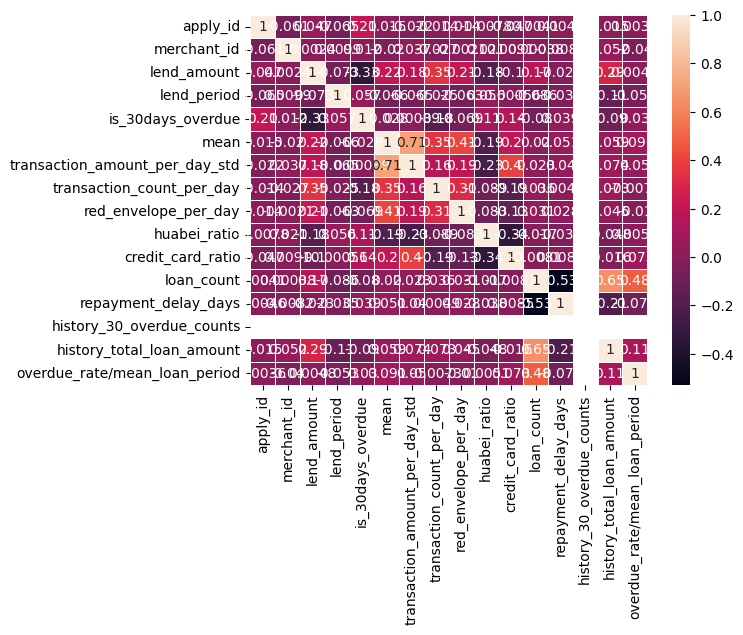

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# 选择数值型的列
numerical_columns = df_train.select_dtypes(include=['float64', 'int64'])
# 计算数据相关性矩阵
correlation_matrix = numerical_columns.corr()
# 热力图
sns.heatmap(correlation_matrix, square=False, linewidths=.5, annot=True)

## 5 模型引入

### 5.1 随机森林模型

由于训练集中包含缺失值，决策树可以处理缺失值的特征并进行预测。随机森林是一种集成学习方法，它通过构建多个决策树来进行预测，然后通过取这些树的输出的平均值（回归问题）或投票（分类问题）来提高模型的准确性和鲁棒性。随机森林具有很强的泛化能力，对于复杂的数据集和高维特征空间也表现良好。

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

In [32]:
# 数据划分，将20%的数据用作验证集
X_train, X_val, y_train, y_val = train_test_split(normalized_X, y, test_size=0.2, random_state = 43)

In [33]:
classifier = RandomForestClassifier(random_state=43)
# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [4, 8, 10]
}

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# 在训练数据上进行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳得分
print("最佳参数:", grid_search.best_params_)
print("最佳得分:", grid_search.best_score_)

最佳参数: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 100}
最佳得分: 0.7218749999999999


Accuracy: 0.7083
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.80      0.78       154
         1.0       0.60      0.55      0.57        86

    accuracy                           0.71       240
   macro avg       0.68      0.67      0.68       240
weighted avg       0.70      0.71      0.70       240



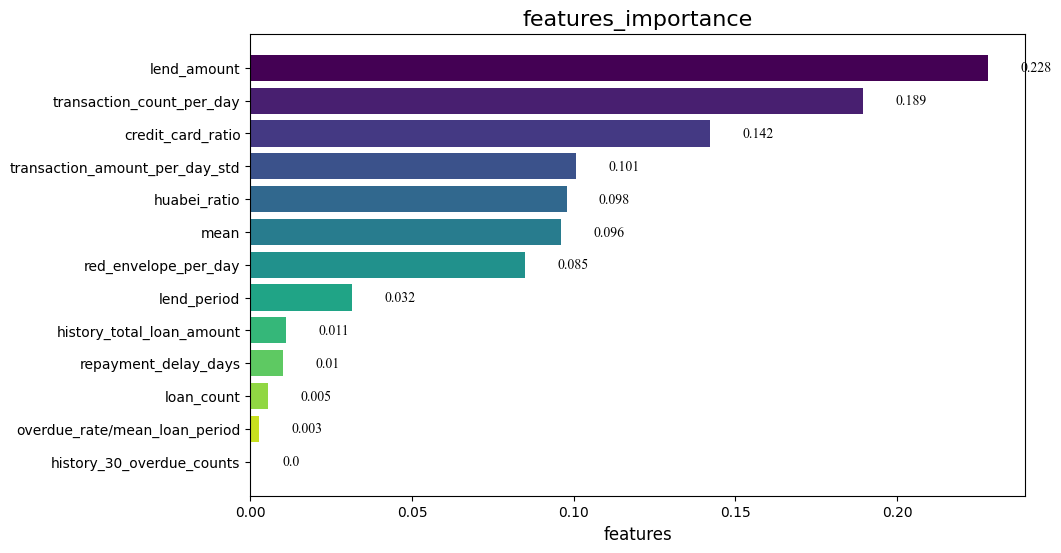

In [34]:
best_classifier_RF = RandomForestClassifier(max_depth=10, 
                                         min_samples_leaf=8, 
                                         min_samples_split=5, 
                                         n_estimators=100,
                                         random_state=43
                                        )
# 训练模型
best_classifier_RF.fit(X_train, y_train)
 
# 在验证集上进行预测
y_pred = best_classifier_RF.predict(X_val)
 
# 评估模型性能
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')
 
# 输出更详细的分类报告
print('Classification Report:\n', classification_report(y_val, y_pred))


# 特征重要性可视化
# 获取特征重要性得分
feature_importances = best_classifier_RF.feature_importances_

# 对特征重要性得分进行排序
feature_names = list(X.columns)
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importances_df['feature'], feature_importances_df['importance'], color=colors)
ax.invert_yaxis()  # 翻转y轴，使得最大的特征在最上面
ax.set_xlabel('features', fontsize=12)
ax.set_title('features_importance',fontsize=16)
for i, v in enumerate(feature_importances_df['importance']):
    ax.text(v + 0.01, i, str(round(v, 3)), va='center', fontname='Times New Roman', fontsize=10)

plt.show()

### 5.2 XGBOOST模型

In [35]:
import xgboost as xgb

In [36]:
# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.35],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [0, 0.1, 0.01, 0.001]
}

# 创建模型对象
model = xgb.XGBClassifier()

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# 在训练数据上进行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳得分
print("最佳参数:", grid_search.best_params_)
print("最佳得分:", grid_search.best_score_)

最佳参数: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.1}
最佳得分: 0.7062499999999999


Accuracy: 0.6958
Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.81      0.77       154
         1.0       0.59      0.49      0.54        86

    accuracy                           0.70       240
   macro avg       0.67      0.65      0.65       240
weighted avg       0.69      0.70      0.69       240



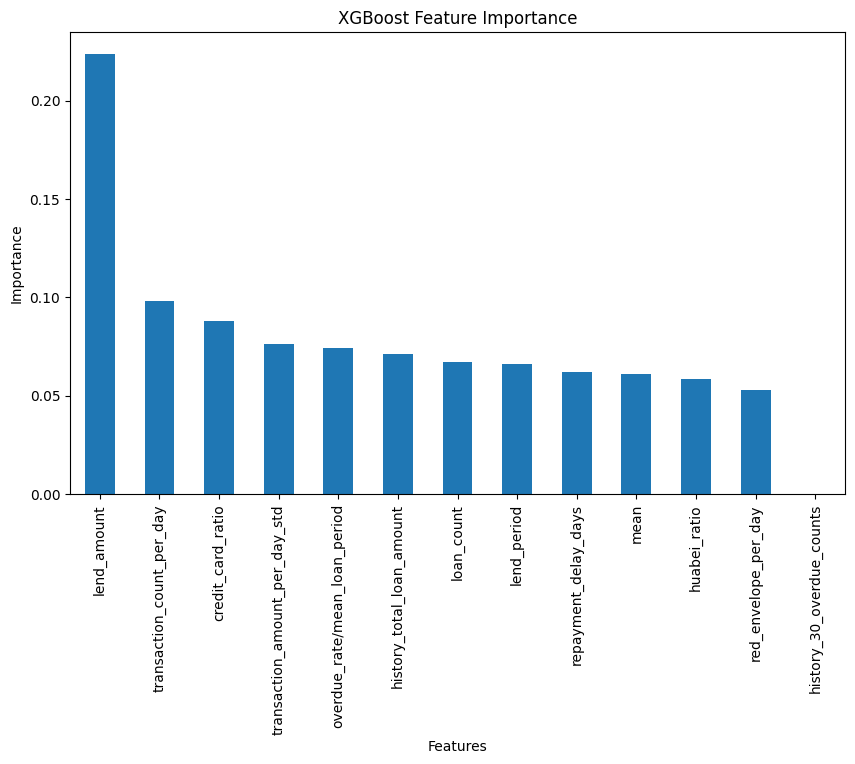

In [37]:
best_classifier_XGB = xgb.XGBClassifier(learning_rate=0.1, 
                                    max_depth=3, 
                                    n_estimators=100, 
                                    reg_alpha=0.01, 
                                    reg_lambda=0.1,
                                    random_state=43
                                   )
# 训练模型
best_classifier_XGB.fit(X_train, y_train)
 
# 在验证集上进行预测
y_pred = best_classifier_XGB.predict(X_val)
 
# 评估模型性能
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')
 
# 输出更详细的分类报告
print('Classification Report:\n', classification_report(y_val, y_pred))

# 获取特征重要性
importance = best_classifier_XGB.feature_importances_
# 将特征重要性与特征名称对应起来
feature_names = X_train.columns
feature_importance = pd.Series(importance, index=feature_names)
# 对特征重要性进行排序
feature_importance_sorted = feature_importance.sort_values(ascending=False)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
feature_importance_sorted.plot(kind='bar')
plt.title('XGBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### 5.3 MLP模型

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [39]:
# 初始化 MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, alpha=0.01, solver='adam', random_state=43)

# 训练模型
mlp.fit(X_train, y_train)

# 预测
y_pred = mlp.predict(X_val)

# 评估模型
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[117  37]
 [ 39  47]]
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75       154
         1.0       0.56      0.55      0.55        86

    accuracy                           0.68       240
   macro avg       0.65      0.65      0.65       240
weighted avg       0.68      0.68      0.68       240



/opt/anaconda3/envs/data_mining/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 6 测试集的处理

### 6.1 测试集的流水数据

In [40]:
# 将流水数据与测试集merge
loss_data = loan_data_test.merge(loss_data, on='merchant_id', how='left')
print(loss_data.info())

loss_data.to_csv("loss_data.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995842 entries, 0 to 995841
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   apply_id               995842 non-null  int64  
 1   merchant_id            995842 non-null  int64  
 2   apply_date             995842 non-null  object 
 3   lend_amount            995842 non-null  float64
 4   lend_period            995842 non-null  int64  
 5   id                     995825 non-null  object 
 6   type                   995825 non-null  float64
 7   status                 995825 non-null  float64
 8   store_id               995825 non-null  float64
 9   pay_way                995825 non-null  float64
 10  sub_pay_way            995825 non-null  float64
 11  paid_amount            995825 non-null  object 
 12  ctime                  995825 non-null  float64
 13  bankcard_credit        995825 non-null  float64
 14  bankcard_debit         995825 non-nu

In [41]:
loss_data['apply_date'] = pd.to_datetime(loss_data['apply_date'])
loss_data['pt'] = pd.to_datetime(loss_data['pt'], format='%Y%m%d')
#loss_data['paid_amount'] = pd.to_numeric(loss_data['paid_amount'])
loss_data['bankcard_credit'] = pd.to_numeric(loss_data['bankcard_credit'])
loss_data['bankcard_debit'] = pd.to_numeric(loss_data['bankcard_debit'])
loss_data['wallet_weixin'] = pd.to_numeric(loss_data['wallet_weixin'])
loss_data['wallet_alipay'] = pd.to_numeric(loss_data['wallet_alipay'])
loss_data['wallet_alipay_finance'] = pd.to_numeric(loss_data['wallet_alipay_finance'])
loss_data['alipay_huabei'] = pd.to_numeric(loss_data['alipay_huabei'])
loss_data['alipay_point'] = pd.to_numeric(loss_data['alipay_point'])
#print(loss_data['bankcard_credit'].dtype)
#print(loss_data)

In [42]:
# 删除已取消的交易（loss_data['type']值为10的行）
loss_data = loss_data[loss_data['type'] != 10]
print("删除已取消的交易后，流水数据的数据量为", loss_data.shape[0])

# 删除无意义的交易（即'paid_amount'为'\N'且bankcard_credit、bankcard_debit、wallet_weixin、wallet_alipay、wallet_alipay_finance、alipay_huabei、alipay_point的值均为0的列）
loss_data['paid_amount'] = loss_data['paid_amount'].replace(r'\N', np.nan) # 将‘\N’替换为空值
loss_data['paid_amount'] = pd.to_numeric(loss_data['paid_amount'])# 将['paid_amount']列转换为数字类型，方便求均值
meaningless_transactions = loss_data[(loss_data['paid_amount'].isnull()) & 
                                           (loss_data['bankcard_credit'] == 0) &
                                           (loss_data['bankcard_debit'] == 0) &
                                           (loss_data['wallet_weixin'] == 0) &
                                           (loss_data['wallet_alipay'] == 0) &
                                           (loss_data['wallet_alipay_finance'] == 0) &
                                           (loss_data['alipay_huabei'] == 0) &
                                           (loss_data['alipay_point'] == 0)] # 创建条件索引，找出'paid_amount'为NaN且其他支付方式均为0的行
loss_data.drop(meaningless_transactions.index, inplace=True)
print("删除无意义的交易后，流水数据的数据量为：", loss_data.shape[0])

# 对于['paid_amount']列，使用该商铺该日收入均值替代值为‘\N’的列
store_income_per_day = loss_data.groupby(['store_id'])['paid_amount'].mean() # 使用该商铺的日收入均值替代空值
print(store_income_per_day)
store_income_per_day = store_income_per_day.astype('O')
loss_data['paid_amount'].fillna(loss_data.apply(lambda row: store_income_per_day.get((row['store_id'])), axis=1), inplace=True)

#loss_data['paid_amount'] = loss_data['paid_amount'].fillna(store_income_per_day)
print("替换后，流水数据为：", loss_data)

删除已取消的交易后，流水数据的数据量为 995308
删除无意义的交易后，流水数据的数据量为： 944828
store_id
5.153257e+11    36362.283825
1.920140e+12     7338.789700
3.872919e+12        1.000000
6.928169e+12      433.596665
7.258285e+12    29598.613333
                    ...     
9.832422e+14    15336.697917
9.834611e+14     1572.462180
9.837029e+14     1283.822684
9.943470e+14     2890.616667
9.956510e+14      725.962440
Name: paid_amount, Length: 590, dtype: float64
替换后，流水数据为：         apply_id      merchant_id apply_date  lend_amount  lend_period  \
0       50557025   40407382055696 2018-05-14       3000.0           12   
1       50557025   40407382055696 2018-05-14       3000.0           12   
2       50557025   40407382055696 2018-05-14       3000.0           12   
3       50557025   40407382055696 2018-05-14       3000.0           12   
4       50557025   40407382055696 2018-05-14       3000.0           12   
...          ...              ...        ...          ...          ...   
995837  50390497  497377049261045 2018-05

/var/folders/l8/wygybflx5kv0zwk02x748tn80000gn/T/ipykernel_37529/4134706920.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loss_data['paid_amount'].fillna(loss_data.apply(lambda row: store_income_per_day.get((row['store_id'])), axis=1), inplace=True)


In [43]:
loss_data['paid_amount'] = loss_data['paid_amount'] / 100
loss_data['bankcard_credit'] = loss_data['bankcard_credit'] / 100
loss_data['bankcard_debit'] = loss_data['bankcard_debit'] / 100
loss_data['wallet_weixin'] = loss_data['wallet_weixin'] / 100
loss_data['wallet_alipay'] = loss_data['wallet_alipay'] /100
loss_data['wallet_alipay_finance'] = loss_data['wallet_alipay_finance'] / 100
loss_data['alipay_huabei'] = loss_data['alipay_huabei'] / 100
loss_data['alipay_point'] = loss_data['alipay_point'] / 100
print(loss_data)

        apply_id      merchant_id apply_date  lend_amount  lend_period  \
0       50557025   40407382055696 2018-05-14       3000.0           12   
1       50557025   40407382055696 2018-05-14       3000.0           12   
2       50557025   40407382055696 2018-05-14       3000.0           12   
3       50557025   40407382055696 2018-05-14       3000.0           12   
4       50557025   40407382055696 2018-05-14       3000.0           12   
...          ...              ...        ...          ...          ...   
995837  50390497  497377049261045 2018-05-13      20000.0            3   
995838  50390497  497377049261045 2018-05-13      20000.0            3   
995839  50390497  497377049261045 2018-05-13      20000.0            3   
995840  50390497  497377049261045 2018-05-13      20000.0            3   
995841  50390497  497377049261045 2018-05-13      20000.0            3   

                       id  type  status      store_id  pay_way  ...  \
0       t7895258623863223  30.0  2000.0 

In [44]:
# 将在apply_date之前30天的流水数据视为有效数据，删除其他数据
loss_data = loss_data[(loss_data['apply_date'] - loss_data['pt']).dt.days.le(30)]
print(loss_data)

        apply_id      merchant_id apply_date  lend_amount  lend_period  \
0       50557025   40407382055696 2018-05-14       3000.0           12   
1       50557025   40407382055696 2018-05-14       3000.0           12   
2       50557025   40407382055696 2018-05-14       3000.0           12   
3       50557025   40407382055696 2018-05-14       3000.0           12   
4       50557025   40407382055696 2018-05-14       3000.0           12   
...          ...              ...        ...          ...          ...   
995837  50390497  497377049261045 2018-05-13      20000.0            3   
995838  50390497  497377049261045 2018-05-13      20000.0            3   
995839  50390497  497377049261045 2018-05-13      20000.0            3   
995840  50390497  497377049261045 2018-05-13      20000.0            3   
995841  50390497  497377049261045 2018-05-13      20000.0            3   

                       id  type  status      store_id  pay_way  ...  \
0       t7895258623863223  30.0  2000.0 

In [45]:
print(loss_data.groupby('merchant_id')['apply_date'].unique().shape[0])

481


#### 6.1.1 获取商户金额均值（每日

In [46]:
# 计算每个商户的交易金额统计特征（申请前30天）
transaction_amount_statistics_per_merchant = loss_data.groupby(['merchant_id', 'apply_date', loss_data['pt'].dt.date])['paid_amount'].sum()
transaction_amount_statistics_per_merchant_per_day = transaction_amount_statistics_per_merchant.groupby(['merchant_id', 'apply_date']).agg(['mean', 'sum', 'max', 'min']).reset_index()

print("\n每个商户的交易金额统计特征：")
print(transaction_amount_statistics_per_merchant_per_day)


每个商户的交易金额统计特征：
         merchant_id apply_date          mean        sum       max       min
0      4438120154392 2018-05-08   2049.352727   22542.88  10000.01     30.00
1      7016886982744 2018-05-17    140.125000    1121.00    295.00     50.00
2      7362163203486 2018-05-27   4019.543810   84410.42   8927.85    900.00
3     10001782380154 2018-05-22    567.854000   22714.16    952.18     19.00
4     14056953414473 2018-05-17   5364.147167  321848.83  18797.74   1588.00
..               ...        ...           ...        ...       ...       ...
480  991176064417345 2018-06-08  24583.190263  934161.23  56444.74  12869.75
481  993492192219716 2018-05-04    160.750000     643.00    283.00    105.00
482  996389374126439 2018-06-06   1068.733750    8549.87   3056.00      1.02
483  996858225667641 2018-06-09    285.879524    6003.47    627.00     30.00
484  997450569402569 2018-05-03   2649.244459  196044.09   6230.45      8.00

[485 rows x 6 columns]


#### 6.1.2 获取商户金额标准差（每日

In [47]:
# 根据商户分组并计算交易总金额和交易金额的标准差（申请前30天）
merchant_activity = loss_data.groupby(['merchant_id', 'apply_date', loss_data['pt'].dt.date])['paid_amount'].sum()
merchant_activity_per_day = merchant_activity.groupby(['merchant_id', 'apply_date']).std()

# 重命名列名
merchant_activity_per_day.columns = ['transaction_amount_std']
merchant_activity_per_day = merchant_activity_per_day.reset_index(name='transaction_amount_per_day_std')

# 显示结果
print(merchant_activity_per_day)
print(merchant_activity_per_day.info())

         merchant_id apply_date  transaction_amount_per_day_std
0      4438120154392 2018-05-08                     3049.828321
1      7016886982744 2018-05-17                       96.616233
2      7362163203486 2018-05-27                     1837.038003
3     10001782380154 2018-05-22                      210.534709
4     14056953414473 2018-05-17                     3838.191373
..               ...        ...                             ...
480  991176064417345 2018-06-08                     9487.170080
481  993492192219716 2018-05-04                       83.715291
482  996389374126439 2018-06-06                      996.189148
483  996858225667641 2018-06-09                      143.028728
484  997450569402569 2018-05-03                     1569.251737

[485 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                         

#### 6.1.3 商户平均每日交易数

In [48]:
# 计算每个商户每日平均交易次数（申请前30天）
transaction_count_per_day = loss_data.groupby(['merchant_id', 'apply_date', loss_data['pt'].dt.date]).size()
transaction_count_per_day_per_merchant = transaction_count_per_day.groupby(['merchant_id', 'apply_date']).mean().reset_index(name='transaction_count_per_day')

print("每个商户平均每日交易数量：")
print(transaction_count_per_day_per_merchant)

每个商户平均每日交易数量：
         merchant_id apply_date  transaction_count_per_day
0      4438120154392 2018-05-08                   1.454545
1      7016886982744 2018-05-17                   1.875000
2      7362163203486 2018-05-27                  12.952381
3     10001782380154 2018-05-22                  43.825000
4     14056953414473 2018-05-17                  53.800000
..               ...        ...                        ...
480  991176064417345 2018-06-08                 130.500000
481  993492192219716 2018-05-04                   1.250000
482  996389374126439 2018-06-06                   6.750000
483  996858225667641 2018-06-09                   9.000000
484  997450569402569 2018-05-03                 103.513514

[485 rows x 3 columns]


#### 6.1.4 平均每日红包使用金额

In [49]:
# 商户平均每日红包使用金额（申请前30天）
loss_data['red_envelope'] = loss_data['paid_amount'] - loss_data[['bankcard_credit', 'bankcard_debit', 'wallet_weixin', 'wallet_alipay', 'wallet_alipay_finance', 'alipay_huabei', 'alipay_point']].sum(axis=1)
#print(loss_data)
merchant_red_envelope = loss_data.groupby(['merchant_id', 'apply_date', loss_data['pt'].dt.date])['red_envelope'].sum()
merchant_red_envelope_per_day = merchant_red_envelope.groupby(['merchant_id', 'apply_date']).mean().reset_index(name='red_envelope_per_day')
print(merchant_red_envelope_per_day)

         merchant_id apply_date  red_envelope_per_day
0      4438120154392 2018-05-08              0.000000
1      7016886982744 2018-05-17              0.000000
2      7362163203486 2018-05-27             58.511429
3     10001782380154 2018-05-22              0.975000
4     14056953414473 2018-05-17             50.989167
..               ...        ...                   ...
480  991176064417345 2018-06-08            184.359737
481  993492192219716 2018-05-04              0.000000
482  996389374126439 2018-06-06              9.750000
483  996858225667641 2018-06-09              0.000000
484  997450569402569 2018-05-03              2.601757

[485 rows x 3 columns]


#### 6.1.5 花呗/信用卡支付占该商铺总支付金额的占比

In [50]:
# 计算每个商户的总支付金额（申请前30天）
total_payment_per_merchant = loss_data.groupby(['merchant_id', 'apply_date'])[['bankcard_debit', 'wallet_weixin', 'wallet_alipay', 'wallet_alipay_finance', 'bankcard_credit', 'alipay_huabei', 'alipay_point']].sum()
total_payment_per_merchant['total_payment'] = total_payment_per_merchant.sum(axis=1)

# 计算信用卡支付金额与总支付金额的比例
credit_card_payment_ratio_per_merchant = total_payment_per_merchant['bankcard_credit'] / total_payment_per_merchant['total_payment']
credit_card_payment_ratio_per_merchant = credit_card_payment_ratio_per_merchant.reset_index(name='credit_card_ratio')
# 计算花呗支付金额与总支付金额的比例
huabei_payment_ratio_per_merchant = total_payment_per_merchant['alipay_huabei'] / total_payment_per_merchant['total_payment']
huabei_payment_ratio_per_merchant = huabei_payment_ratio_per_merchant.reset_index(name='huabei_ratio')

# 显示结果
print("信用卡支付金额与总支付金额的比例（按商户）：")
print(credit_card_payment_ratio_per_merchant)

print("\n花呗支付金额与总支付金额的比例（按商户）：")
print(huabei_payment_ratio_per_merchant)

信用卡支付金额与总支付金额的比例（按商户）：
         merchant_id apply_date  credit_card_ratio
0      4438120154392 2018-05-08           0.990063
1      7016886982744 2018-05-17           0.000000
2      7362163203486 2018-05-27           0.128403
3     10001782380154 2018-05-22           0.031635
4     14056953414473 2018-05-17           0.056620
..               ...        ...                ...
480  991176064417345 2018-06-08           0.187402
481  993492192219716 2018-05-04           0.000000
482  996389374126439 2018-06-06           0.188506
483  996858225667641 2018-06-09           0.080935
484  997450569402569 2018-05-03           0.189279

[485 rows x 3 columns]

花呗支付金额与总支付金额的比例（按商户）：
         merchant_id apply_date  huabei_ratio
0      4438120154392 2018-05-08      0.004392
1      7016886982744 2018-05-17      0.098127
2      7362163203486 2018-05-27      0.109676
3     10001782380154 2018-05-22      0.038576
4     14056953414473 2018-05-17      0.067464
..               ...        ...           

### 6.3 数据整合

In [51]:
# 流水数据
loan_data_test['apply_date'] = pd.to_datetime(loan_data_test['apply_date'])
# 商户金额均值（每日
df_test = loan_data_test.merge(transaction_amount_statistics_per_merchant_per_day[['merchant_id', 'apply_date', 'mean']], on=['merchant_id', 'apply_date'], how='left')
# 商户金额标准差（每日
df_test = df_test.merge(merchant_activity_per_day, on=['merchant_id', 'apply_date'], how='left')
# 商户平均每日交易数
df_test = df_test.merge(transaction_count_per_day_per_merchant, on=['merchant_id', 'apply_date'], how='left')
# 平均每日红包使用金额
df_test = df_test.merge(merchant_red_envelope_per_day, on=['merchant_id', 'apply_date'], how='left')
# 花呗/信用卡支付占该商铺总支付金额的占比
df_test = df_test.merge(huabei_payment_ratio_per_merchant, on=['merchant_id', 'apply_date'], how='left')
df_test = df_test.merge(credit_card_payment_ratio_per_merchant, on=['merchant_id', 'apply_date'], how='left')
df_test = df_test.select_dtypes(include=['float64', 'int64'])
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   apply_id                        515 non-null    int64  
 1   merchant_id                     515 non-null    int64  
 2   lend_amount                     515 non-null    float64
 3   lend_period                     515 non-null    int64  
 4   mean                            485 non-null    float64
 5   transaction_amount_per_day_std  469 non-null    float64
 6   transaction_count_per_day       485 non-null    float64
 7   red_envelope_per_day            485 non-null    float64
 8   huabei_ratio                    485 non-null    float64
 9   credit_card_ratio               485 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 40.4 KB
None


In [52]:
#使用KNN插补对空缺值进行填补
from sklearn.impute import KNNImputer

df = df_test.copy()
df = df.drop(columns=['apply_id', 'merchant_id'])

def optimize_k(data, target):
    errors = []
    for k in range(1, 12, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(df)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = mean_squared_error(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

k_errors = optimize_k(data=df, target=['mean', 'transaction_amount_per_day_std', 'transaction_count_per_day', 'red_envelope_per_day', 'huabei_ratio', 'credit_card_ratio'])
print(k_errors)

[{'K': 1, 'RMSE': 4287899.085840244}, {'K': 3, 'RMSE': 4126034.571821416}, {'K': 5, 'RMSE': 4086073.29080967}, {'K': 7, 'RMSE': 4064750.3997773645}, {'K': 9, 'RMSE': 4113368.083257005}, {'K': 11, 'RMSE': 4130826.03203979}]


In [53]:
#使用KNN插补对空缺值进行填补
imputer = KNNImputer(n_neighbors=9)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)

print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lend_amount                     515 non-null    float64
 1   lend_period                     515 non-null    float64
 2   mean                            515 non-null    float64
 3   transaction_amount_per_day_std  515 non-null    float64
 4   transaction_count_per_day       515 non-null    float64
 5   red_envelope_per_day            515 non-null    float64
 6   huabei_ratio                    515 non-null    float64
 7   credit_card_ratio               515 non-null    float64
dtypes: float64(8)
memory usage: 32.3 KB
None


In [54]:
df_test[['lend_amount', 'lend_period', 'mean', 'transaction_amount_per_day_std', 'transaction_count_per_day', 'red_envelope_per_day', 'huabei_ratio', 'credit_card_ratio']] = df_imputed

# 历史贷款数据
# 贷款人历史贷款次数
df_test = df_test.merge(loan_count_per_borrower, on='merchant_id', how='left')
# 贷款人每笔贷款是否逾期/提前还款
df_test = df_test.merge(mean_delay_days_per_merchant, on='merchant_id', how='left')
# 历史30天逾期未还款的次数
df_test = df_test.merge(history_overdue_counts, on='merchant_id', how='left')
# 历史30天逾期还款率
#df_test = df_test.merge(history_merged_data[['merchant_id', 'overdue_rate']], on='merchant_id', how='left')
# 历史贷款总金额
df_test = df_test.merge(history_total_loan_amount, on='merchant_id', how='left')
# 历史逾期率/商户平均贷款期数
df_test = df_test.merge(history_merged_data[['merchant_id', 'overdue_rate/mean_loan_period']], on='merchant_id', how='left')

df_test[['loan_count', 'repayment_delay_days', 'history_30_overdue_counts', 'history_total_loan_amount', 'overdue_rate/mean_loan_period']] = df_test[['loan_count', 'repayment_delay_days', 'history_30_overdue_counts', 'history_total_loan_amount', 'overdue_rate/mean_loan_period']].fillna(0)
print(df_test)

     apply_id      merchant_id  lend_amount  lend_period         mean  \
0    50557025   40407382055696       3000.0         12.0   450.515208   
1    49510913  233357058121933      10000.0          6.0   557.748136   
2    50782824  295347911545545       5000.0          3.0   658.331818   
3    51967846  856779078398919      50000.0         12.0  1485.988409   
4    51105993  549633976173617       5000.0          3.0   755.253889   
..        ...              ...          ...          ...          ...   
510  51298099   32939380854162       1000.0          3.0   199.525000   
511  51727003  876304916318446      80000.0          4.0  1119.164167   
512  51967678  410327776551501       2000.0          3.0    86.024000   
513  50391309  318511520290974      10000.0          6.0  2851.757619   
514  50390497  497377049261045      20000.0          3.0  1731.012500   

     transaction_amount_per_day_std  transaction_count_per_day  \
0                        209.705097                  24.7

In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   apply_id                        515 non-null    int64  
 1   merchant_id                     515 non-null    int64  
 2   lend_amount                     515 non-null    float64
 3   lend_period                     515 non-null    float64
 4   mean                            515 non-null    float64
 5   transaction_amount_per_day_std  515 non-null    float64
 6   transaction_count_per_day       515 non-null    float64
 7   red_envelope_per_day            515 non-null    float64
 8   huabei_ratio                    515 non-null    float64
 9   credit_card_ratio               515 non-null    float64
 10  loan_count                      515 non-null    float64
 11  repayment_delay_days            515 non-null    float64
 12  history_30_overdue_counts       515 

In [56]:
x_test = df_test.drop(columns=['apply_id', 'merchant_id'])
x_test = x_test.select_dtypes(include=['float64', 'int64'])
print(x_test.shape[0])

515


In [57]:
from sklearn.preprocessing import StandardScaler

# 创建一个标准化的对象
scaler = StandardScaler()

# 对DataFrame的每一列进行标准化
normalized_x_test = x_test.copy()  # 复制原始DataFrame
normalized_x_test[x_test.columns] = scaler.fit_transform(x_test[x_test.columns])

# 输出归一化后的DataFrame
print(normalized_x_test)

     lend_amount  lend_period      mean  transaction_amount_per_day_std  \
0      -0.724510     1.235803 -0.501047                       -0.657638   
1      -0.454019    -0.349349 -0.466478                       -0.468298   
2      -0.647227    -1.141925 -0.434052                       -0.386086   
3       1.091641     1.235803 -0.167236                       -0.314030   
4      -0.647227    -1.141925 -0.402807                       -0.568085   
..           ...          ...       ...                             ...   
510    -0.801793    -1.141925 -0.581960                       -0.688321   
511     2.250887    -0.877733 -0.285491                        0.269494   
512    -0.763151    -1.141925 -0.618550                       -0.716734   
513    -0.454019    -0.349349  0.273054                        0.711048   
514    -0.067604    -1.141925 -0.088246                       -0.068085   

     transaction_count_per_day  red_envelope_per_day  huabei_ratio  \
0                    -0.05343

In [58]:
# 对测试集进行预测
# y_pr_RF = best_classifier_RF.predict(normalized_x_test)
y_pr_XGB = best_classifier_XGB.predict(normalized_x_test)
# y_pr_mlp = mlp.predict(normalized_x_test)
# print(y_pr_RF.shape[0])
print(y_pr_XGB)
# print(y_pr_mlp)

[0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0
 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1
 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 1 0 0 0 1 0 0 0 1 

In [59]:
print(df_test['apply_id'])

0      50557025
1      49510913
2      50782824
3      51967846
4      51105993
         ...   
510    51298099
511    51727003
512    51967678
513    50391309
514    50390497
Name: apply_id, Length: 515, dtype: int64


In [60]:
with open("table_loan_predict.txt", 'w') as file:
    file.write('apply_id,predict_label')
    file.write('\n')
    for i in range(515):
        file.write(str(df_test['apply_id'][i]))
        file.write(',')
        file.write(str(y_pr_XGB[i]))
        file.write('\n')
    